Begun 3/22/24

Testing a few more things:
1. Is using a wide range [-30,30] of degrees in the fit messing the fit up?
2. Do we do any better if we use the original map-based estimator?
3. May also get around to testing if the fit is better using D_ell instead of C_ell in the likelihood.

It is also possible that something is amiss in the denominator (covariance) of the EB estimator and that that is causing the issue with the distribution for that estimator.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from pixell import enmap, enplot, reproject, utils, curvedsky
from tqdm import tqdm
#import nawrapper as nw
#import yaml
import time
import healpy as hp

In [2]:
# Load CAMB spectra
ell_camb,DlTT_camb,DlEE_camb,DlBB_camb,DlTE_camb = np.loadtxt( \
            "/home/zbh5/act_analysis/act_axion_analysis/resources/camb_19413797_lensedtotcls.dat", \
                                                              usecols=(0,1,2,3,4), unpack=True) 
# Note that ell_camb runs from 2 to 5400
# Healpy expects ell to start at zero
# Initializing new arrays with first two entries set to zero
arr_len = ell_camb.size+2
ell = np.zeros(arr_len)
ell[1] = 1
ell[2:] = ell_camb
ClTT = np.zeros(arr_len)
ClEE = np.zeros(arr_len)
ClTE = np.zeros(arr_len)
ClBB = np.zeros(arr_len)
# convert Dl to Cl
ClTT[2:] = DlTT_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClEE[2:] = DlEE_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClTE[2:] = DlTE_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClBB[2:] = DlBB_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))

In [3]:
# Functions to calculate likelihood and fit for angle
# These are the only things being tested by these full sky sims at different rotation angles
def estimator_likelihood(angle, estimator, covariance, ClEE):
    """For a given difference in angle between the depth-1 map (map 1) and the coadd (map 2),
       returns the value of the normalized likelihood for our estimator.
       
       ClEE is the theory EE spectrum from CAMB"""

    numerator = (estimator - ClEE*np.sin(2*angle))**2
    denominator = 2*covariance
    likelihood = np.exp(-np.sum(numerator/denominator))
    return likelihood

def null_eb_estimator_likelihood(angle,eb,ee,bb,ClEE):
    """Returns null EB estimator from Keating et al
       eb, ee, and bb are the autospectra from the rotated map in question
       ClEE is the CAMB EE spectrum"""
    numerator = (eb+0.5*ClEE*np.sin(4*angle))**2
    denominator = 2*(ee*bb+eb**2) # Taken from A7 in the Das et al (2011) appendix - 
    # reduces to Keating term in noiseless regime if neglecting sky area factor but not the EB contribution
    likelihood = np.exp(-np.sum(numerator/denominator))
    return likelihood

def gaussian_fit_moment(angles,data):
    """
       Uses moments to quickly find mean and standard deviation of a Gaussian
       for the likelihood.
    """
    mean = np.sum(angles*data)/np.sum(data)
    std_dev = np.sqrt(abs(np.sum((angles-mean)**2*data)/np.sum(data)))
    return mean, std_dev
    
def sample_likelihood_and_fit(estimator,covariance,theory_ClEE,angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=10000):
    """
       Samples likelihood for a range of angles and returns the best fit for the
       mean and median of the resulting Gaussian.  
    """
    if(angle_min_deg >= angle_max_deg): 
        raise ValueError("The min angle must be smaller than the max!")
    angles_deg = np.linspace(angle_min_deg,angle_max_deg,num=num_pts)
    angles_rad = np.deg2rad(angles_deg)
    
    bin_sampled_likelihood = [estimator_likelihood(angle,estimator,covariance,theory_ClEE) for angle in angles_rad]
    norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)
    
    # Switching back to fitting in radians, which I think is more correct. Forgot to do in nb4
    mean, std_dev = gaussian_fit_moment(angles_rad,norm_sampled_likelihood)
    mean *= 180./np.pi
    std_dev *= 180./np.pi
    fit_values = (mean,std_dev)
    
    return fit_values

def sample_null_eb_likelihood_and_fit(eb,ee,bb,theory_ClEE,angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=10000):
    """
       Samples null eb likelihood for a range of angles and returns the best fit for the
       mean and median of the resulting Gaussian.  
    """
    if(angle_min_deg >= angle_max_deg): 
        raise ValueError("The min angle must be smaller than the max!")
    angles_deg = np.linspace(angle_min_deg,angle_max_deg,num=num_pts)
    angles_rad = np.deg2rad(angles_deg)
    
    bin_sampled_likelihood = [null_eb_estimator_likelihood(angle,eb,ee,bb,theory_ClEE) for angle in angles_rad]
    norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)
    
    mean, std_dev = gaussian_fit_moment(angles_rad,norm_sampled_likelihood)
    mean *= 180./np.pi
    std_dev *= 180./np.pi
    fit_values = (mean,std_dev)
    
    return fit_values

In [10]:
def calc_rho_mapspace(rot_Q,rot_U,unrot_Q,unrot_U):
    """
    Uses the Keck map space estimator for the angle (neglecting in-pixel correlations between Q and U)
    This estimator has been adjusted to use the same coordinate system as our angle estimator.
    It also has a factor of 2 difference because of how Q and U are defined relative to the power spectrum estimator.
    """
    rho = np.sum((-1*unrot_Q*unrot_U + rot_Q*unrot_U)+(-1*unrot_Q*rot_U + unrot_Q*unrot_U))/np.sum(unrot_U**2+unrot_Q**2)
    rho /= 2.0 # To measure the same angle as the PS estimators
    rho *= 180./np.pi
    return rho

In [22]:
# Doing 300 sims of full sky maps with an ell range of 200-1000 with a constant angle of 1 deg to
# test the amount of scatter for a fixed angle.
# Also calculating EB angles using unrotated spectra to make sure the distribution is unbiased there
# Also uses an estimator in map space to calculate angles
min_ell = 200
max_ell = 1000
N_sims = 300
nside = 512
npix = nside**2*12
print(hp.nside2resol(nside,arcmin=True))

output_angles = []
output_mapspace_angles = []
output_null_eb_angles = []
output_unrot_null_eb_angles = []
output_spectra = []
tt_bias_outputs = []

rot_degs = np.array(N_sims*[1.0])
#print("Input angles are: " + str(rot_degs))
for rot_deg in tqdm(rot_degs):
    unrot_sim_maps = hp.sphtfunc.synfast((ClTT,ClTE,ClEE,ClBB),nside)
    CMB_Q = unrot_sim_maps[1]
    CMB_U = unrot_sim_maps[2]
    rot_Q_map =  np.cos(np.deg2rad(2*rot_deg))*CMB_Q + np.sin(np.deg2rad(2*rot_deg))*CMB_U
    rot_U_map = -np.sin(np.deg2rad(2*rot_deg))*CMB_Q + np.cos(np.deg2rad(2*rot_deg))*CMB_U
    rot_sim_maps = (unrot_sim_maps[0],rot_Q_map,rot_U_map)
    mapspace_angle = calc_rho_mapspace(rot_Q_map, rot_U_map, CMB_Q, CMB_U)
    output_mapspace_angles.append(mapspace_angle)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps, map2=unrot_sim_maps)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps)
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] 
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] 
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] 
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] 
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] 
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] 
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell]
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell]
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell]
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell]
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell]
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell]
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell]
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell]
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell]
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell]
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell]
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell]
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell]
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell]
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell]
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell]
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell]
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell]
    
    spectra = [ClTT_rot,ClEE_rot,ClBB_rot,ClTE_rot,ClEB_rot,ClTB_rot,
               ClTT_unrot,ClEE_unrot,ClBB_unrot,ClTE_unrot,ClEB_unrot,ClTB_unrot,
               ClTT_cross12,ClEE_cross12,ClBB_cross12,ClTE_cross12,ClEB_cross12,ClTB_cross12,
               ClTT_cross21,ClEE_cross21,ClBB_cross21,ClTE_cross21,ClEB_cross21,ClTB_cross21]
    output_spectra.append(spectra) # Saving all spectra for analyzing them afterwards
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    
    # Using the same angle range and num_pts as Steve's last test
    fit_values = sample_likelihood_and_fit(estimator,covariance,ClEE[min_ell:max_ell],\
                                           angle_min_deg=0.0,angle_max_deg=2.0,num_pts=1000)
    null_eb_fit_values = sample_null_eb_likelihood_and_fit(ClEB_rot,ClEE_rot,ClBB_rot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=0.0,angle_max_deg=2.0,num_pts=1000)
    # This one should be centered around 0, not the input angle
    unrot_null_eb_fit_values = sample_null_eb_likelihood_and_fit(ClEB_unrot,ClEE_unrot,ClBB_unrot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-1.0,angle_max_deg=1.0,num_pts=1000)
    #print("Output angle: " + str(fit_values))
    #print("Output null EB angle: " + str(null_eb_fit_values))
    tt_bias_outputs.append(np.mean(ClTT_rot/ClTT[min_ell:max_ell]))
    output_angles.append(fit_values)
    output_null_eb_angles.append(null_eb_fit_values)
    output_unrot_null_eb_angles.append(unrot_null_eb_fit_values)
    
rot_degs = np.array(rot_degs)
output_angles_only = np.array(output_angles)[:,0]
output_null_eb_angles_only = np.array(output_null_eb_angles)[:,0]
output_unrot_null_eb_angles_only = np.array(output_unrot_null_eb_angles)[:,0]
percent_diff = 100.0*(output_angles_only - rot_degs)/rot_degs
percent_diff_eb = 100.0*(output_null_eb_angles_only - rot_degs)/rot_degs

6.870972823634812


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [1:12:23<00:00, 14.48s/it]


Median of full sky percent error, map based estimator: -0.020306590798047086
Mean of full sky percent error, map based estimator: -0.020306590798038832
Std dev of full sky percent error, map based estimator: 6.547880639005006e-14


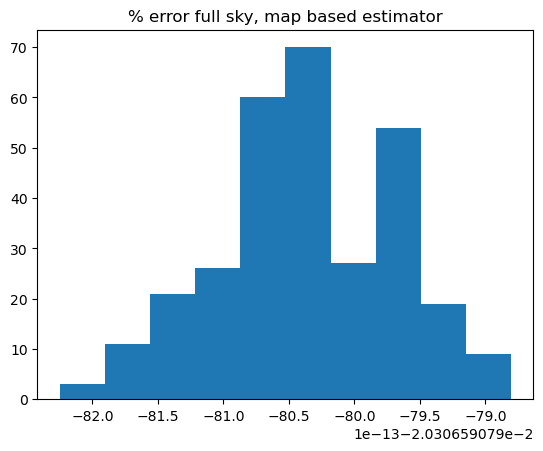

Median of full sky percent error: 0.08313372340125191
Mean of full sky percent error: 0.07017310528949676
Std dev of full sky percent error: 0.164747037831642


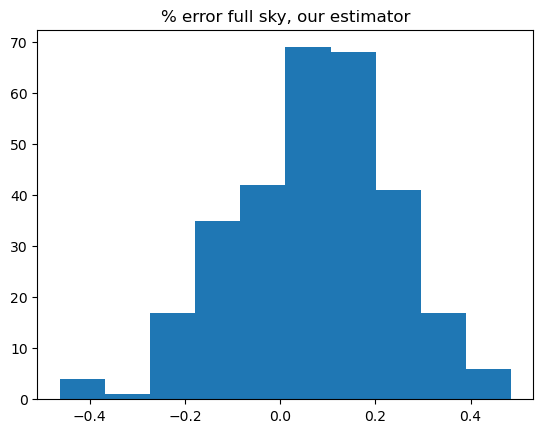

Median of full sky percent error EB estimator: -0.859185782158034
Mean of full sky percent error EB estimator: -0.8558254227589225
Std dev of full sky percent error EB estimator: 0.24264251148137528


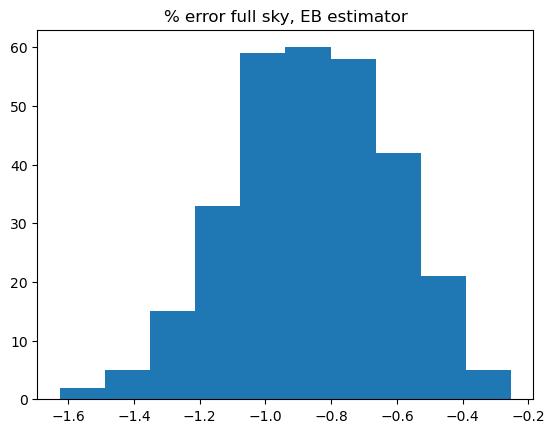

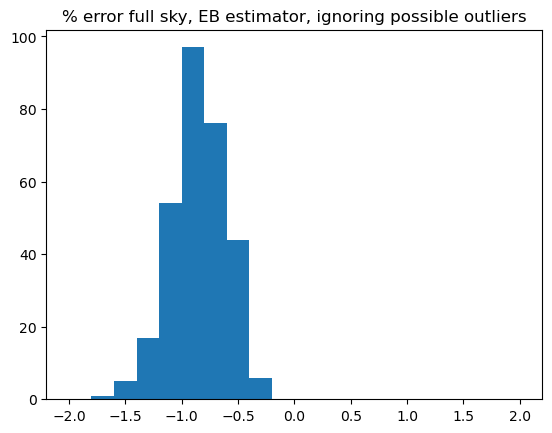

Median of full sky angles Unrot EB estimator: 0.00010257147042444467
Mean of full sky angles Unrot EB estimator: -4.040652432010778e-05
Std dev of full sky angles Unrot EB estimator: 0.0017224613056739024


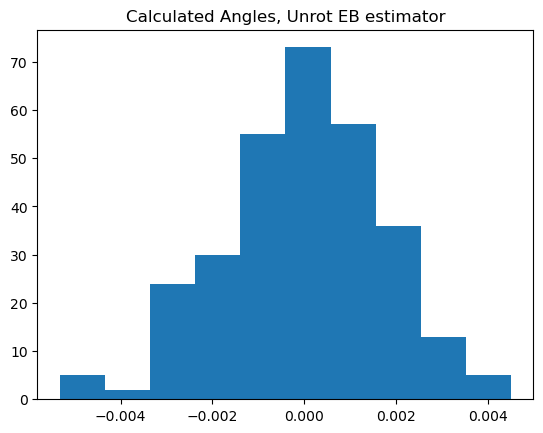

Median of full sky mean TT ratio: 0.9999543853026197
Mean of full sky mean TT ratio: 1.0000711653227194
Std dev of full sky mean TT ratio: 0.0015514626484445402


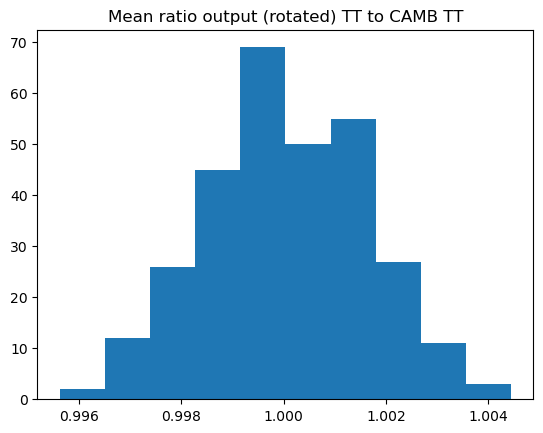

In [23]:
output_mapspace_angles = np.array(output_mapspace_angles)
mapbased_percent_diff = 100.0*(output_mapspace_angles - rot_degs)/rot_degs
print("Median of full sky percent error, map based estimator: " + str(np.median(mapbased_percent_diff)))
print("Mean of full sky percent error, map based estimator: " + str(np.mean(mapbased_percent_diff)))
print("Std dev of full sky percent error, map based estimator: " + str(np.std(mapbased_percent_diff)))
plt.hist(mapbased_percent_diff)
plt.title("% error full sky, map based estimator")
plt.show()
plt.close()

print("Median of full sky percent error: " + str(np.median(percent_diff)))
print("Mean of full sky percent error: " + str(np.mean(percent_diff)))
print("Std dev of full sky percent error: " + str(np.std(percent_diff)))
plt.hist(percent_diff)
plt.title("% error full sky, our estimator")
plt.show()
plt.close()
print("Median of full sky percent error EB estimator: " + str(np.median(percent_diff_eb)))
print("Mean of full sky percent error EB estimator: " + str(np.mean(percent_diff_eb)))
print("Std dev of full sky percent error EB estimator: " + str(np.std(percent_diff_eb)))
plt.hist(percent_diff_eb)
plt.title("% error full sky, EB estimator")
plt.show()
plt.close()
# Plotting in a limited range to ignore large outliers
plt.hist(percent_diff_eb,bins=20,range=(-2,2))
plt.title("% error full sky, EB estimator, ignoring possible outliers")
plt.show()
plt.close()
# We want to see that the distribution of unrotated angles is consistent with zero
# Don't need to calculate percent diff here
print("Median of full sky angles Unrot EB estimator: " + str(np.median(output_unrot_null_eb_angles_only)))
print("Mean of full sky angles Unrot EB estimator: " + str(np.mean(output_unrot_null_eb_angles_only)))
print("Std dev of full sky angles Unrot EB estimator: " + str(np.std(output_unrot_null_eb_angles_only)))
plt.hist(output_unrot_null_eb_angles_only)
plt.title("Calculated Angles, Unrot EB estimator")
plt.show()
plt.close()
print("Median of full sky mean TT ratio: " + str(np.median(tt_bias_outputs)))
print("Mean of full sky mean TT ratio: " + str(np.mean(tt_bias_outputs)))
print("Std dev of full sky mean TT ratio: " + str(np.std(tt_bias_outputs)))
plt.hist(tt_bias_outputs)
plt.title("Mean ratio output (rotated) TT to CAMB TT")
plt.show()
plt.close()

In [24]:
# Doing 300 sims of full sky maps with an ell range of 200-1000 with a constant angle of 5 deg to
# test the amount of scatter for a fixed angle.
# Also calculating EB angles using unrotated spectra to make sure the distribution is unbiased there
# Also uses an estimator in map space to calculate angles

# Difference from last time is setting input angle to 5 deg 
min_ell = 200
max_ell = 1000
N_sims = 300
nside = 512
npix = nside**2*12
print(hp.nside2resol(nside,arcmin=True))

output_angles = []
output_mapspace_angles = []
output_null_eb_angles = []
output_unrot_null_eb_angles = []
output_spectra = []
tt_bias_outputs = []

rot_degs = np.array(N_sims*[5.0])
#print("Input angles are: " + str(rot_degs))
for rot_deg in tqdm(rot_degs):
    unrot_sim_maps = hp.sphtfunc.synfast((ClTT,ClTE,ClEE,ClBB),nside)
    CMB_Q = unrot_sim_maps[1]
    CMB_U = unrot_sim_maps[2]
    rot_Q_map =  np.cos(np.deg2rad(2*rot_deg))*CMB_Q + np.sin(np.deg2rad(2*rot_deg))*CMB_U
    rot_U_map = -np.sin(np.deg2rad(2*rot_deg))*CMB_Q + np.cos(np.deg2rad(2*rot_deg))*CMB_U
    rot_sim_maps = (unrot_sim_maps[0],rot_Q_map,rot_U_map)
    mapspace_angle = calc_rho_mapspace(rot_Q_map, rot_U_map, CMB_Q, CMB_U)
    output_mapspace_angles.append(mapspace_angle)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps, map2=unrot_sim_maps)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps)
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] 
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] 
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] 
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] 
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] 
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] 
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell]
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell]
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell]
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell]
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell]
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell]
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell]
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell]
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell]
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell]
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell]
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell]
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell]
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell]
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell]
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell]
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell]
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell]
    
    spectra = [ClTT_rot,ClEE_rot,ClBB_rot,ClTE_rot,ClEB_rot,ClTB_rot,
               ClTT_unrot,ClEE_unrot,ClBB_unrot,ClTE_unrot,ClEB_unrot,ClTB_unrot,
               ClTT_cross12,ClEE_cross12,ClBB_cross12,ClTE_cross12,ClEB_cross12,ClTB_cross12,
               ClTT_cross21,ClEE_cross21,ClBB_cross21,ClTE_cross21,ClEB_cross21,ClTB_cross21]
    output_spectra.append(spectra) # Saving all spectra for analyzing them afterwards
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    
    # Using the same angle range and num_pts as Steve's last test
    fit_values = sample_likelihood_and_fit(estimator,covariance,ClEE[min_ell:max_ell],\
                                           angle_min_deg=4.0,angle_max_deg=6.0,num_pts=1000)
    null_eb_fit_values = sample_null_eb_likelihood_and_fit(ClEB_rot,ClEE_rot,ClBB_rot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=4.0,angle_max_deg=6.0,num_pts=1000)
    unrot_null_eb_fit_values = sample_null_eb_likelihood_and_fit(ClEB_unrot,ClEE_unrot,ClBB_unrot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-1.0,angle_max_deg=1.0,num_pts=1000)
    #print("Output angle: " + str(fit_values))
    #print("Output null EB angle: " + str(null_eb_fit_values))
    tt_bias_outputs.append(np.mean(ClTT_rot/ClTT[min_ell:max_ell]))
    output_angles.append(fit_values)
    output_null_eb_angles.append(null_eb_fit_values)
    output_unrot_null_eb_angles.append(unrot_null_eb_fit_values)
    
rot_degs = np.array(rot_degs)
output_angles_only = np.array(output_angles)[:,0]
output_null_eb_angles_only = np.array(output_null_eb_angles)[:,0]
output_unrot_null_eb_angles_only = np.array(output_unrot_null_eb_angles)[:,0]
percent_diff = 100.0*(output_angles_only - rot_degs)/rot_degs
percent_diff_eb = 100.0*(output_null_eb_angles_only - rot_degs)/rot_degs
output_mapspace_angles = np.array(output_mapspace_angles)
mapbased_percent_diff = 100.0*(output_mapspace_angles - rot_degs)/rot_degs

6.870972823634812


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [1:11:58<00:00, 14.40s/it]


Median of full sky percent error, map based estimator: -0.5069229954701449
Mean of full sky percent error, map based estimator: -0.5069229954701396
Std dev of full sky percent error, map based estimator: 7.258179857781038e-14


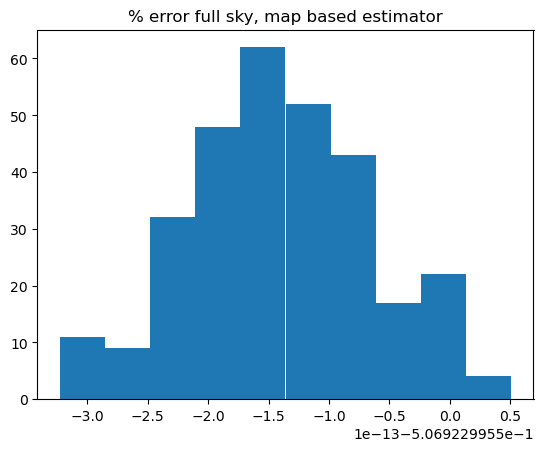

Median of full sky percent error: 0.07402739446943585
Mean of full sky percent error: 0.07228022088026147
Std dev of full sky percent error: 0.15379148202147488


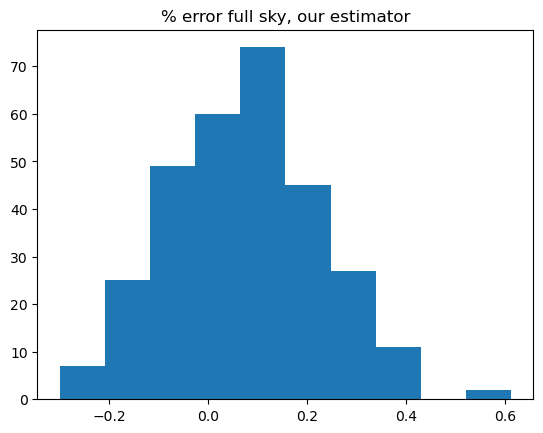

Median of full sky percent error EB estimator: -0.8565544794771363
Mean of full sky percent error EB estimator: -0.8602211560133746
Std dev of full sky percent error EB estimator: 0.1622475758690084


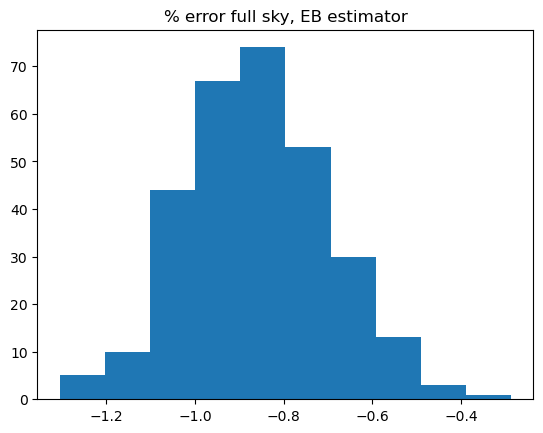

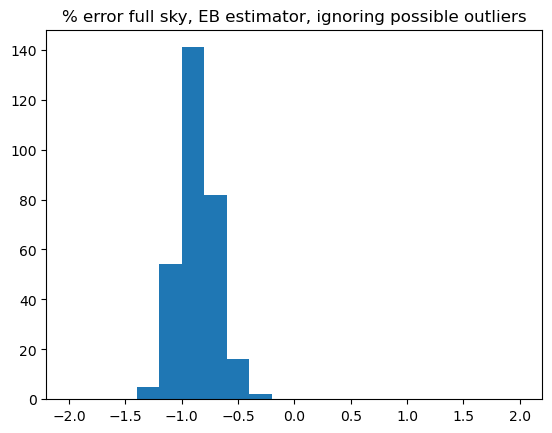

Median of full sky angles Unrot EB estimator: -0.00019348133524166842
Mean of full sky angles Unrot EB estimator: -0.00018464598776681953
Std dev of full sky angles Unrot EB estimator: 0.0016993007885911116


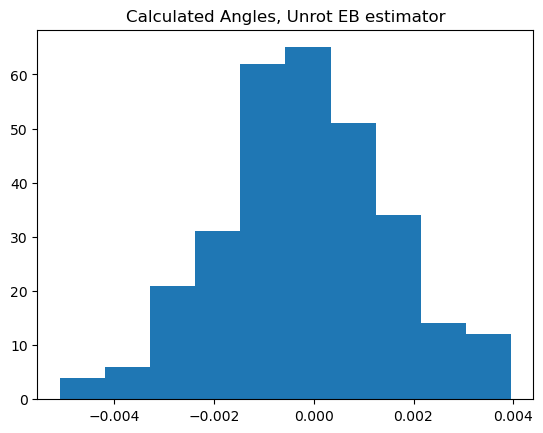

Median of full sky mean TT ratio: 1.0001251424199826
Mean of full sky mean TT ratio: 1.0000785133095889
Std dev of full sky mean TT ratio: 0.0015561548548744374


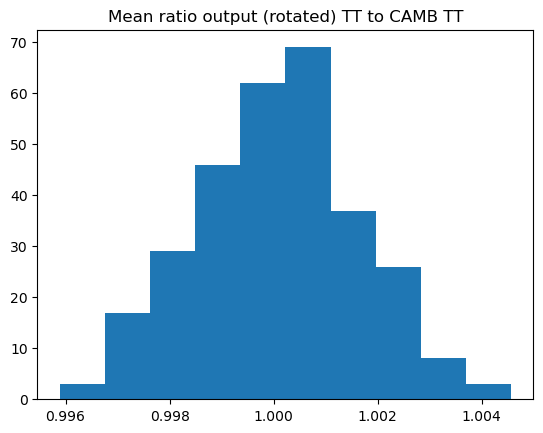

In [25]:
output_mapspace_angles = np.array(output_mapspace_angles)
mapbased_percent_diff = 100.0*(output_mapspace_angles - rot_degs)/rot_degs
print("Median of full sky percent error, map based estimator: " + str(np.median(mapbased_percent_diff)))
print("Mean of full sky percent error, map based estimator: " + str(np.mean(mapbased_percent_diff)))
print("Std dev of full sky percent error, map based estimator: " + str(np.std(mapbased_percent_diff)))
plt.hist(mapbased_percent_diff)
plt.title("% error full sky, map based estimator")
plt.show()
plt.close()

print("Median of full sky percent error: " + str(np.median(percent_diff)))
print("Mean of full sky percent error: " + str(np.mean(percent_diff)))
print("Std dev of full sky percent error: " + str(np.std(percent_diff)))
plt.hist(percent_diff)
plt.title("% error full sky, our estimator")
plt.show()
plt.close()
print("Median of full sky percent error EB estimator: " + str(np.median(percent_diff_eb)))
print("Mean of full sky percent error EB estimator: " + str(np.mean(percent_diff_eb)))
print("Std dev of full sky percent error EB estimator: " + str(np.std(percent_diff_eb)))
plt.hist(percent_diff_eb)
plt.title("% error full sky, EB estimator")
plt.show()
plt.close()
# Plotting in a limited range to ignore large outliers
plt.hist(percent_diff_eb,bins=20,range=(-2,2))
plt.title("% error full sky, EB estimator, ignoring possible outliers")
plt.show()
plt.close()
# We want to see that the distribution of unrotated angles is consistent with zero
# Don't need to calculate percent diff here
print("Median of full sky angles Unrot EB estimator: " + str(np.median(output_unrot_null_eb_angles_only)))
print("Mean of full sky angles Unrot EB estimator: " + str(np.mean(output_unrot_null_eb_angles_only)))
print("Std dev of full sky angles Unrot EB estimator: " + str(np.std(output_unrot_null_eb_angles_only)))
plt.hist(output_unrot_null_eb_angles_only)
plt.title("Calculated Angles, Unrot EB estimator")
plt.show()
plt.close()
print("Median of full sky mean TT ratio: " + str(np.median(tt_bias_outputs)))
print("Mean of full sky mean TT ratio: " + str(np.mean(tt_bias_outputs)))
print("Std dev of full sky mean TT ratio: " + str(np.std(tt_bias_outputs)))
plt.hist(tt_bias_outputs)
plt.title("Mean ratio output (rotated) TT to CAMB TT")
plt.show()
plt.close()

In [26]:
# Doing 300 sims of full sky maps with an ell range of 200-1000 with a constant angle of 1 deg to
# test the amount of scatter for a fixed angle.
# Also calculating EB angles using unrotated spectra to make sure the distribution is unbiased there
# Also uses an estimator in map space to calculate angles

# Back to using a 1 deg angle, but testing a larger fit range to see if that leads to more variation in the fits
min_ell = 200
max_ell = 1000
N_sims = 300
nside = 512
npix = nside**2*12
print(hp.nside2resol(nside,arcmin=True))

output_angles = []
output_mapspace_angles = []
output_null_eb_angles = []
output_unrot_null_eb_angles = []
output_spectra = []
tt_bias_outputs = []

rot_degs = np.array(N_sims*[1.0])
#print("Input angles are: " + str(rot_degs))
for rot_deg in tqdm(rot_degs):
    unrot_sim_maps = hp.sphtfunc.synfast((ClTT,ClTE,ClEE,ClBB),nside)
    CMB_Q = unrot_sim_maps[1]
    CMB_U = unrot_sim_maps[2]
    rot_Q_map =  np.cos(np.deg2rad(2*rot_deg))*CMB_Q + np.sin(np.deg2rad(2*rot_deg))*CMB_U
    rot_U_map = -np.sin(np.deg2rad(2*rot_deg))*CMB_Q + np.cos(np.deg2rad(2*rot_deg))*CMB_U
    rot_sim_maps = (unrot_sim_maps[0],rot_Q_map,rot_U_map)
    mapspace_angle = calc_rho_mapspace(rot_Q_map, rot_U_map, CMB_Q, CMB_U)
    output_mapspace_angles.append(mapspace_angle)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps, map2=unrot_sim_maps)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps)
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] 
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] 
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] 
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] 
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] 
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] 
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell]
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell]
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell]
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell]
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell]
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell]
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell]
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell]
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell]
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell]
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell]
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell]
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell]
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell]
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell]
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell]
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell]
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell]
    
    spectra = [ClTT_rot,ClEE_rot,ClBB_rot,ClTE_rot,ClEB_rot,ClTB_rot,
               ClTT_unrot,ClEE_unrot,ClBB_unrot,ClTE_unrot,ClEB_unrot,ClTB_unrot,
               ClTT_cross12,ClEE_cross12,ClBB_cross12,ClTE_cross12,ClEB_cross12,ClTB_cross12,
               ClTT_cross21,ClEE_cross21,ClBB_cross21,ClTE_cross21,ClEB_cross21,ClTB_cross21]
    output_spectra.append(spectra) # Saving all spectra for analyzing them afterwards
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    
    # Expanding the range from 2 deg to 12 deg around the real angle; scaling number of points up by factor of 6 too
    fit_values = sample_likelihood_and_fit(estimator,covariance,ClEE[min_ell:max_ell],\
                                           angle_min_deg=-5.0,angle_max_deg=7.0,num_pts=6000)
    null_eb_fit_values = sample_null_eb_likelihood_and_fit(ClEB_rot,ClEE_rot,ClBB_rot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-5.0,angle_max_deg=7.0,num_pts=6000)
    # This one should be centered around 0, not the input angle
    unrot_null_eb_fit_values = sample_null_eb_likelihood_and_fit(ClEB_unrot,ClEE_unrot,ClBB_unrot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-6.0,angle_max_deg=6.0,num_pts=6000)
    #print("Output angle: " + str(fit_values))
    #print("Output null EB angle: " + str(null_eb_fit_values))
    tt_bias_outputs.append(np.mean(ClTT_rot/ClTT[min_ell:max_ell]))
    output_angles.append(fit_values)
    output_null_eb_angles.append(null_eb_fit_values)
    output_unrot_null_eb_angles.append(unrot_null_eb_fit_values)
    
rot_degs = np.array(rot_degs)
output_angles_only = np.array(output_angles)[:,0]
output_null_eb_angles_only = np.array(output_null_eb_angles)[:,0]
output_unrot_null_eb_angles_only = np.array(output_unrot_null_eb_angles)[:,0]
percent_diff = 100.0*(output_angles_only - rot_degs)/rot_degs
percent_diff_eb = 100.0*(output_null_eb_angles_only - rot_degs)/rot_degs
output_mapspace_angles = np.array(output_mapspace_angles)
mapbased_percent_diff = 100.0*(output_mapspace_angles - rot_degs)/rot_degs

6.870972823634812


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [1:12:49<00:00, 14.57s/it]


Median of full sky percent error, map based estimator: -0.020306590798047086
Mean of full sky percent error, map based estimator: -0.02030659079804753
Std dev of full sky percent error, map based estimator: 7.036140060534007e-14


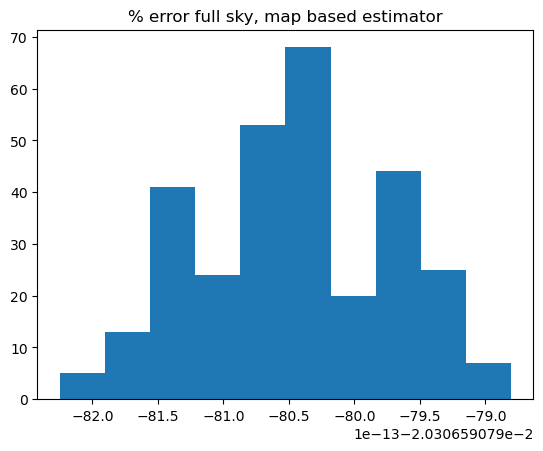

Median of full sky percent error: 0.07733094237640792
Mean of full sky percent error: 0.07559638685132566
Std dev of full sky percent error: 0.1540391401144419


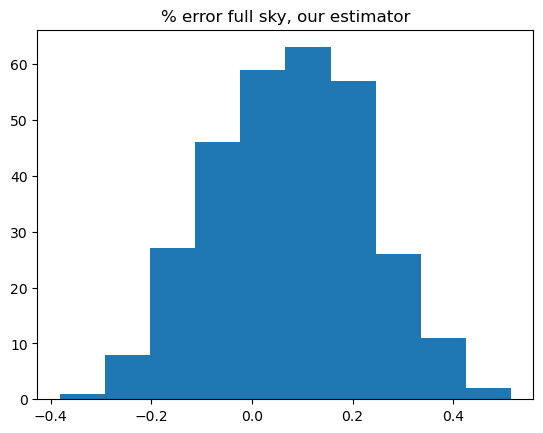

Median of full sky percent error EB estimator: -0.8586291021978276
Mean of full sky percent error EB estimator: -0.8528238599090046
Std dev of full sky percent error EB estimator: 0.24060375705240822


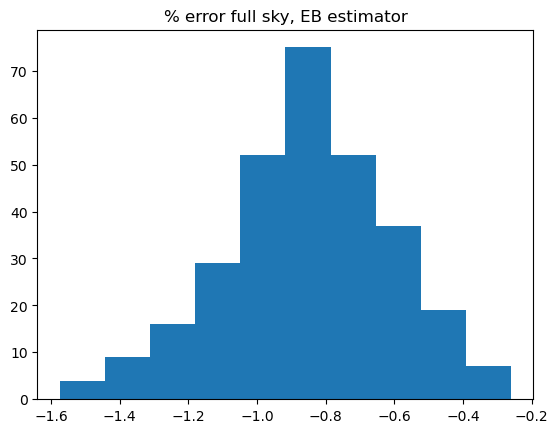

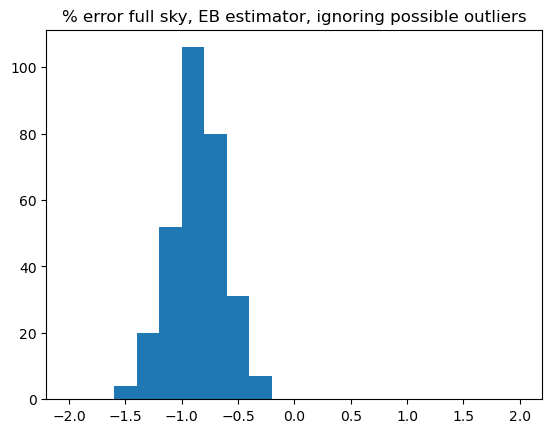

Median of full sky angles Unrot EB estimator: 2.5832363080880383e-05
Mean of full sky angles Unrot EB estimator: -5.8721357833045905e-05
Std dev of full sky angles Unrot EB estimator: 0.0018792043286141528


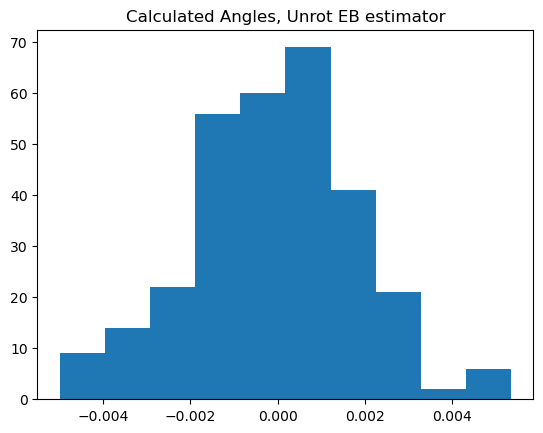

Median of full sky mean TT ratio: 0.999963790580989
Mean of full sky mean TT ratio: 0.9999165903598101
Std dev of full sky mean TT ratio: 0.0015521445021710112


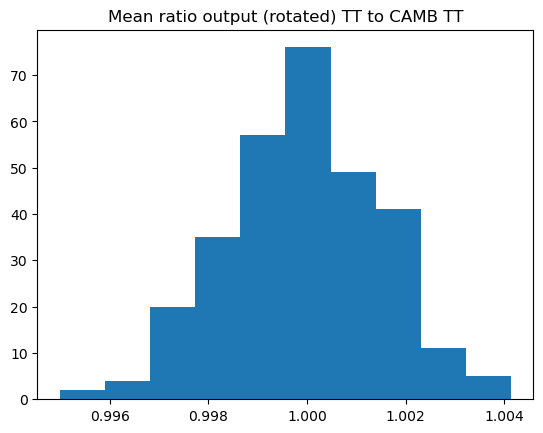

In [27]:
output_mapspace_angles = np.array(output_mapspace_angles)
mapbased_percent_diff = 100.0*(output_mapspace_angles - rot_degs)/rot_degs
print("Median of full sky percent error, map based estimator: " + str(np.median(mapbased_percent_diff)))
print("Mean of full sky percent error, map based estimator: " + str(np.mean(mapbased_percent_diff)))
print("Std dev of full sky percent error, map based estimator: " + str(np.std(mapbased_percent_diff)))
plt.hist(mapbased_percent_diff)
plt.title("% error full sky, map based estimator")
plt.show()
plt.close()

print("Median of full sky percent error: " + str(np.median(percent_diff)))
print("Mean of full sky percent error: " + str(np.mean(percent_diff)))
print("Std dev of full sky percent error: " + str(np.std(percent_diff)))
plt.hist(percent_diff)
plt.title("% error full sky, our estimator")
plt.show()
plt.close()
print("Median of full sky percent error EB estimator: " + str(np.median(percent_diff_eb)))
print("Mean of full sky percent error EB estimator: " + str(np.mean(percent_diff_eb)))
print("Std dev of full sky percent error EB estimator: " + str(np.std(percent_diff_eb)))
plt.hist(percent_diff_eb)
plt.title("% error full sky, EB estimator")
plt.show()
plt.close()
# Plotting in a limited range to ignore large outliers
plt.hist(percent_diff_eb,bins=20,range=(-2,2))
plt.title("% error full sky, EB estimator, ignoring possible outliers")
plt.show()
plt.close()
# We want to see that the distribution of unrotated angles is consistent with zero
# Don't need to calculate percent diff here
print("Median of full sky angles Unrot EB estimator: " + str(np.median(output_unrot_null_eb_angles_only)))
print("Mean of full sky angles Unrot EB estimator: " + str(np.mean(output_unrot_null_eb_angles_only)))
print("Std dev of full sky angles Unrot EB estimator: " + str(np.std(output_unrot_null_eb_angles_only)))
plt.hist(output_unrot_null_eb_angles_only)
plt.title("Calculated Angles, Unrot EB estimator")
plt.show()
plt.close()
print("Median of full sky mean TT ratio: " + str(np.median(tt_bias_outputs)))
print("Mean of full sky mean TT ratio: " + str(np.mean(tt_bias_outputs)))
print("Std dev of full sky mean TT ratio: " + str(np.std(tt_bias_outputs)))
plt.hist(tt_bias_outputs)
plt.title("Mean ratio output (rotated) TT to CAMB TT")
plt.show()
plt.close()

In [30]:
# Doing 300 sims of full sky maps with an ell range of 200-1000 with a constant angle of 1 deg to
# test the amount of scatter for a fixed angle.
# Also calculating EB angles using unrotated spectra to make sure the distribution is unbiased there
# Also uses an estimator in map space to calculate angles

# Using the original fit range but setting covariances to 1 to see if that affects PS fits
def null_eb_estimator_likelihood(angle,eb,ee,bb,ClEE):
    """Returns null EB estimator from Keating et al
       eb, ee, and bb are the autospectra from the rotated map in question
       ClEE is the CAMB EE spectrum"""
    numerator = (eb+0.5*ClEE*np.sin(4*angle))**2
    denominator = 2.0
    likelihood = np.exp(-np.sum(numerator/denominator))
    return likelihood

min_ell = 200
max_ell = 1000
N_sims = 300
nside = 512
npix = nside**2*12
print(hp.nside2resol(nside,arcmin=True))

output_angles = []
output_mapspace_angles = []
output_null_eb_angles = []
output_unrot_null_eb_angles = []
output_spectra = []
tt_bias_outputs = []

rot_degs = np.array(N_sims*[1.0])
#print("Input angles are: " + str(rot_degs))
for rot_deg in tqdm(rot_degs):
    unrot_sim_maps = hp.sphtfunc.synfast((ClTT,ClTE,ClEE,ClBB),nside)
    CMB_Q = unrot_sim_maps[1]
    CMB_U = unrot_sim_maps[2]
    rot_Q_map =  np.cos(np.deg2rad(2*rot_deg))*CMB_Q + np.sin(np.deg2rad(2*rot_deg))*CMB_U
    rot_U_map = -np.sin(np.deg2rad(2*rot_deg))*CMB_Q + np.cos(np.deg2rad(2*rot_deg))*CMB_U
    rot_sim_maps = (unrot_sim_maps[0],rot_Q_map,rot_U_map)
    mapspace_angle = calc_rho_mapspace(rot_Q_map, rot_U_map, CMB_Q, CMB_U)
    output_mapspace_angles.append(mapspace_angle)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps, map2=unrot_sim_maps)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps)
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] 
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] 
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] 
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] 
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] 
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] 
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell]
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell]
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell]
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell]
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell]
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell]
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell]
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell]
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell]
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell]
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell]
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell]
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell]
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell]
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell]
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell]
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell]
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell]
    
    spectra = [ClTT_rot,ClEE_rot,ClBB_rot,ClTE_rot,ClEB_rot,ClTB_rot,
               ClTT_unrot,ClEE_unrot,ClBB_unrot,ClTE_unrot,ClEB_unrot,ClTB_unrot,
               ClTT_cross12,ClEE_cross12,ClBB_cross12,ClTE_cross12,ClEB_cross12,ClTB_cross12,
               ClTT_cross21,ClEE_cross21,ClBB_cross21,ClTE_cross21,ClEB_cross21,ClTB_cross21]
    output_spectra.append(spectra) # Saving all spectra for analyzing them afterwards
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    
    # Back to the original fit range; setting covariances to 1
    covariance = 1.0
    fit_values = sample_likelihood_and_fit(estimator,covariance,ClEE[min_ell:max_ell],\
                                           angle_min_deg=0.0,angle_max_deg=2.0,num_pts=1000)
    null_eb_fit_values = sample_null_eb_likelihood_and_fit(ClEB_rot,ClEE_rot,ClBB_rot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=0.0,angle_max_deg=2.0,num_pts=1000)
    # This one should be centered around 0, not the input angle
    unrot_null_eb_fit_values = sample_null_eb_likelihood_and_fit(ClEB_unrot,ClEE_unrot,ClBB_unrot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-1.0,angle_max_deg=1.0,num_pts=1000)
    #print("Output angle: " + str(fit_values))
    #print("Output null EB angle: " + str(null_eb_fit_values))
    tt_bias_outputs.append(np.mean(ClTT_rot/ClTT[min_ell:max_ell]))
    output_angles.append(fit_values)
    output_null_eb_angles.append(null_eb_fit_values)
    output_unrot_null_eb_angles.append(unrot_null_eb_fit_values)
    
rot_degs = np.array(rot_degs)
output_angles_only = np.array(output_angles)[:,0]
output_null_eb_angles_only = np.array(output_null_eb_angles)[:,0]
output_unrot_null_eb_angles_only = np.array(output_unrot_null_eb_angles)[:,0]
percent_diff = 100.0*(output_angles_only - rot_degs)/rot_degs
percent_diff_eb = 100.0*(output_null_eb_angles_only - rot_degs)/rot_degs
output_mapspace_angles = np.array(output_mapspace_angles)
mapbased_percent_diff = 100.0*(output_mapspace_angles - rot_degs)/rot_degs

6.870972823634812


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [1:11:02<00:00, 14.21s/it]


Median of full sky percent error, map based estimator: -0.020306590798047086
Mean of full sky percent error, map based estimator: -0.020306590798043794
Std dev of full sky percent error, map based estimator: 6.893700294230335e-14


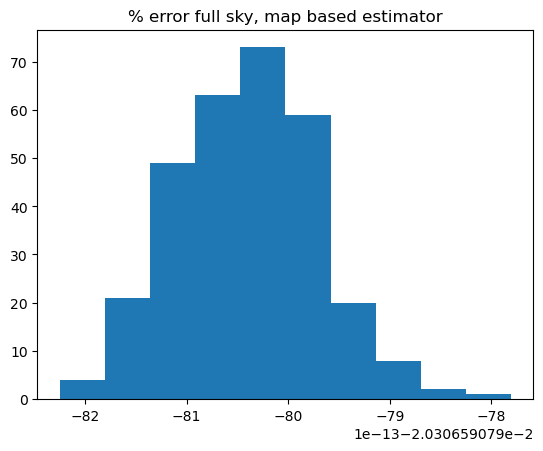

Median of full sky percent error: 2.2212554018352648e-08
Mean of full sky percent error: 2.082819409536067e-08
Std dev of full sky percent error: 1.990932515406358e-08


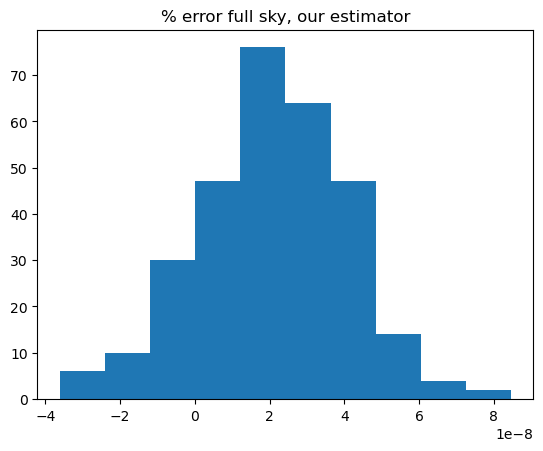

Median of full sky percent error EB estimator: -8.714906574169845e-09
Mean of full sky percent error EB estimator: -8.294714988939708e-09
Std dev of full sky percent error EB estimator: 2.7810263979916565e-08


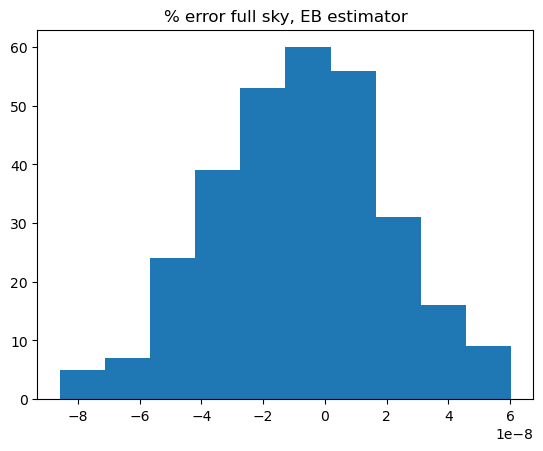

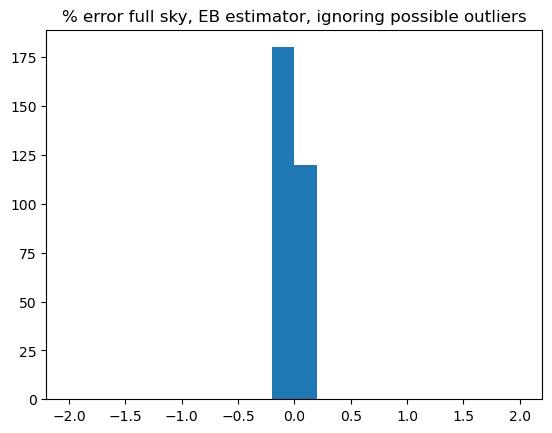

Median of full sky angles Unrot EB estimator: 7.167850950696465e-12
Mean of full sky angles Unrot EB estimator: 2.933982580565861e-12
Std dev of full sky angles Unrot EB estimator: 1.8542551480881737e-10


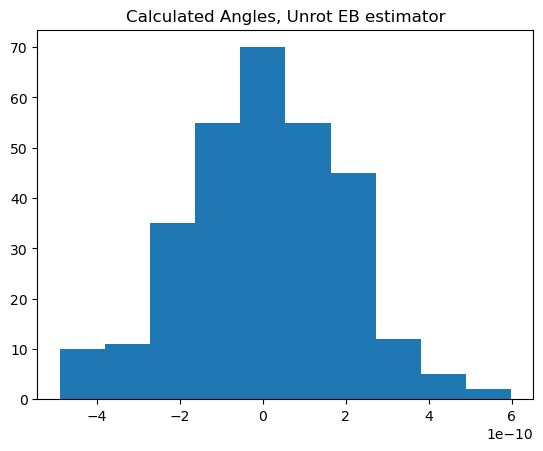

Median of full sky mean TT ratio: 0.9999437456661024
Mean of full sky mean TT ratio: 0.9998578091209578
Std dev of full sky mean TT ratio: 0.0016342775200253448


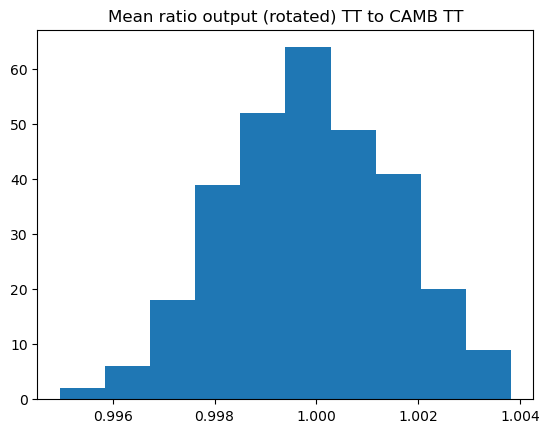

In [31]:
output_mapspace_angles = np.array(output_mapspace_angles)
mapbased_percent_diff = 100.0*(output_mapspace_angles - rot_degs)/rot_degs
print("Median of full sky percent error, map based estimator: " + str(np.median(mapbased_percent_diff)))
print("Mean of full sky percent error, map based estimator: " + str(np.mean(mapbased_percent_diff)))
print("Std dev of full sky percent error, map based estimator: " + str(np.std(mapbased_percent_diff)))
plt.hist(mapbased_percent_diff)
plt.title("% error full sky, map based estimator")
plt.show()
plt.close()

print("Median of full sky percent error: " + str(np.median(percent_diff)))
print("Mean of full sky percent error: " + str(np.mean(percent_diff)))
print("Std dev of full sky percent error: " + str(np.std(percent_diff)))
plt.hist(percent_diff)
plt.title("% error full sky, our estimator")
plt.show()
plt.close()
print("Median of full sky percent error EB estimator: " + str(np.median(percent_diff_eb)))
print("Mean of full sky percent error EB estimator: " + str(np.mean(percent_diff_eb)))
print("Std dev of full sky percent error EB estimator: " + str(np.std(percent_diff_eb)))
plt.hist(percent_diff_eb)
plt.title("% error full sky, EB estimator")
plt.show()
plt.close()
# Plotting in a limited range to ignore large outliers
plt.hist(percent_diff_eb,bins=20,range=(-2,2))
plt.title("% error full sky, EB estimator, ignoring possible outliers")
plt.show()
plt.close()
# We want to see that the distribution of unrotated angles is consistent with zero
# Don't need to calculate percent diff here
print("Median of full sky angles Unrot EB estimator: " + str(np.median(output_unrot_null_eb_angles_only)))
print("Mean of full sky angles Unrot EB estimator: " + str(np.mean(output_unrot_null_eb_angles_only)))
print("Std dev of full sky angles Unrot EB estimator: " + str(np.std(output_unrot_null_eb_angles_only)))
plt.hist(output_unrot_null_eb_angles_only)
plt.title("Calculated Angles, Unrot EB estimator")
plt.show()
plt.close()
print("Median of full sky mean TT ratio: " + str(np.median(tt_bias_outputs)))
print("Mean of full sky mean TT ratio: " + str(np.mean(tt_bias_outputs)))
print("Std dev of full sky mean TT ratio: " + str(np.std(tt_bias_outputs)))
plt.hist(tt_bias_outputs)
plt.title("Mean ratio output (rotated) TT to CAMB TT")
plt.show()
plt.close()

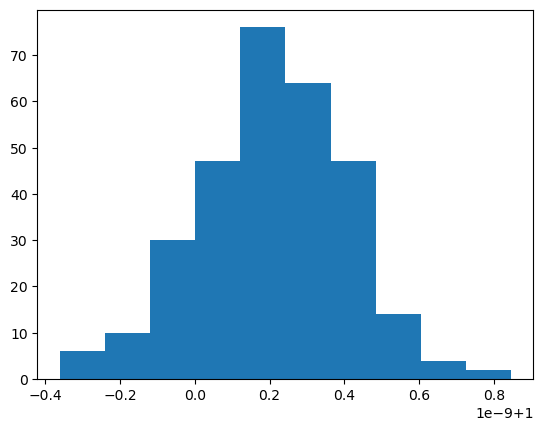

In [40]:
plt.hist(output_angles_only)
plt.show()
plt.close()

0.9999999998954155
1.823184107575299e-10
-1.0458445220962176e-08


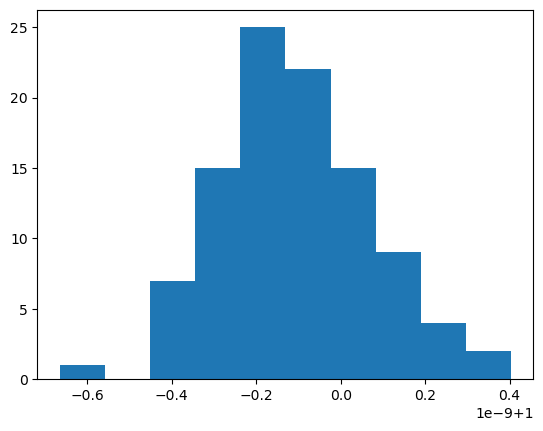

In [47]:
# Retesting Steve's quick test with the covariance set to 1 (but using C_ell instead of D_ell)

import copy

nside = 256
N_sim = 100
rot_deg = 1.0
lmin = 60

angs = []
for i in range(N_sim):
    unrot_sim_maps = hp.sphtfunc.synfast((ClTT,ClTE,ClEE,ClBB),nside)
    
    CMB_Q = copy.copy(unrot_sim_maps[1])
    CMB_U = copy.copy(unrot_sim_maps[2])
    rot_Q_map =  np.cos(np.radians(2*rot_deg))*CMB_Q + np.sin(np.radians(2*rot_deg))*CMB_U
    rot_U_map = -np.sin(np.radians(2*rot_deg))*CMB_Q + np.cos(np.radians(2*rot_deg))*CMB_U
    
    rot_sim_maps = (unrot_sim_maps[0],rot_Q_map,rot_U_map)
    
    cls = hp.anafast(unrot_sim_maps,lmax=nside*2)
    clsrot = hp.anafast(rot_sim_maps,lmax=nside*2)
    
    #dl = (ell*(ell+1)/(2*np.pi))[:(len(cls[0]))]
    
    ang_samp = np.radians(np.linspace(rot_deg-1.,rot_deg+1.,1000))
    
    like = [np.exp(-np.sum((clsrot[4]+0.5*np.sin(4*ang)*cls[1])[lmin:]**2)/2.0) for ang in ang_samp]
    
    mean, std = gaussian_fit_moment(ang_samp,like)
    angs.append(np.degrees(mean))
    
angs = np.array(angs)
plt.hist(angs)
print(np.mean(angs))
print(np.std(angs))
print((np.mean(angs)-rot_deg)/rot_deg*100)